# TODOs

Fixes:
- n_states fix (for 3-channel phi)
- incomplete direct method

Missing data for the following channel triads for "direct" and "logistic3" method:

In [10]:
missing = set({'0-5-12',
 '0-5-13',
 '0-5-14',
 '0-6-7',
 '1-2-4',
 '1-2-5',
 '1-2-6',
 '1-2-7',
 '1-5-12',
 '10-11-14',
 '10-12-13',
 '10-12-14',
 '10-13-14',
 '3-4-13',
 '3-4-14',
 '3-5-6',
 '3-5-7',
 '5-8-10',
 '5-8-11',
 '5-8-12',
 '5-8-13',
 '6-7-10',
 '6-7-14',
 '6-8-10',
 '6-8-11',
 '6-8-9'}
)

In [6]:
with open("../scripts/parallel_phi/networks_3ch") as infile:
    networks_3ch = infile.read().rstrip().splitlines()

In [14]:
for network in networks_3ch:
    if "-".join(network.split(",")[1:]) in missing:
        print(network)

52,0,5,12
53,0,5,13
54,0,5,14
55,0,6,7
92,1,2,4
93,1,2,5
94,1,2,6
95,1,2,7
130,1,5,12
243,3,4,13
244,3,4,14
245,3,5,6
246,3,5,7
351,5,8,10
352,5,8,11
353,5,8,12
354,5,8,13
373,6,7,10
377,6,7,14
378,6,8,9
379,6,8,10
380,6,8,11
447,10,11,14
448,10,12,13
449,10,12,14
450,10,13,14


# Setup

In [29]:
import matplotlib.pyplot as plt
from math import floor

import numpy as np
import scipy.io as sio

import glob
import os
import re

import itertools

from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.model_selection import cross_val_score

plt.rcParams['figure.figsize'] = [15, 5]
%matplotlib inline

A useful toggle-code cell will help make this notebook tidier.

In [3]:
from IPython.display import HTML

In [16]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()"><h1>Toggle Code Visibility</h1></a>.''')

## Data

In [4]:
data_binarised_file = "../data/processed/fly_data_binarised"
data_binarised = np.load(data_binarised_file + ".npy")

In [5]:
data_binarised.shape

(2250, 15, 8, 13, 2)

In [6]:
n_samples, n_channels, n_trials, n_flies, n_conds = data_binarised.shape

## Utility Functions

In [7]:
def extract_value(data, i_result, field):
    """ Extracts a value from the ch_group_results data structure.
    
    Args:
        data: The processed data structure from sio.loadmat[data_field]
        i_result: The index of the result in the data structure.
        field: A string, which must be one of:
            - "state_phis"
            - "tpm"
            - "state_counts"
            - "i_trial"
            - "i_fly"
            - "i_cond"
            - "channels"
            - "all"
    
    Returns:
        A np.ndarray of the extracted data.
    
    """
    
    if field == "state_phis" or field == "channels" or field == "state_counts":
        return data[0, i_result][0, 0][field].flatten()
    elif field == "i_trial" or field == "i_cond" or field == "i_fly":
        return data[0, i_result][0, 0][field][0, 0]
    elif field == "tpm":
        return data[0, i_result][0, 0][field]
    elif field == "all":
        return data[0, i_result][0, 0]
    else:
        raise ValueError("Field not recognised in input data.")

# Control Data

Let's use the Pearson's correlation coefficient between every pair of 2 channels as a control measure for decoding.

In [49]:
%%time
cs = itertools.combinations(range(15), 2)

control_data = []

for c in cs:
    data_c = {}
    data_c["ch_group"] = c

    data = []
    
    for i_trial in range(n_trials):
        for i_fly in range(n_flies):
            for i_cond in range(n_conds):
                coeff = np.corrcoef(data_binarised[:, c[0], i_trial, i_fly, i_cond],
                                    data_binarised[:, c[1], i_trial, i_fly, i_cond]
                                   )
                data_dict = {}
                data_dict["i_trial"] = i_trial
                data_dict["i_fly"] = i_fly
                data_dict["i_cond"] = i_cond
                data_dict["corr_coef"] = coeff[0, 1]
                data.append(data_dict)
    data_c["data"] = data
    
    control_data.append(data_c)

CPU times: user 5.53 s, sys: 33.7 ms, total: 5.56 s
Wall time: 5.58 s


# Decoding

## Decoding Functions

In [17]:
def pool_samples(ch_num, across_flies=True):
    
    method_results = []
    
    glob_str_ch_num = "../data/processed/phis/PHI_{}*.mat".format(ch_num)
    files_ch_num = glob.glob(glob_str_ch_num)
    
    methods = set(map(lambda x: re.search(r"METHOD_(.*?)_", x).group(1), files_ch_num))
    
    for method in methods:
        glob_str_file = "../data/processed/phis/PHI_{}_METHOD_{}*.mat".format(ch_num, method)
        file_list = glob.glob(glob_str_file)
        
        if across_flies:
            ch_results = np.zeros((n_trials * n_conds * n_flies , len(file_list)))
        else:
            ch_results = np.zeros((n_trials * n_conds, n_flies, len(file_list)))

        ch_groups = list(map(lambda x: re.findall(r"\d+", x.split("CHS_")[1]), file_list))
        
        for i_f, filename in enumerate(file_list):
            
            file_results = sio.loadmat(filename)
            data = file_results["ch_group_results"]
            
            xs = np.zeros((n_trials * n_conds, n_flies))
            
            if i_f == 0: # only run once, should be same for all
                ys = np.zeros((n_trials * n_conds, n_flies))
            
            n_results = data.shape[1]
            
            for i_r in range(n_results):
                i_trial = extract_value(data, i_r, "i_trial")
                i_fly = extract_value(data, i_r, "i_fly")
                
                phis = extract_value(data, i_r, "state_phis")
                counts = extract_value(data, i_r, "state_counts")
                if ch_num == 3: # this run had a superfluous state
                    phis = phis[:-1]
                weighted_phi = (phis * (counts / counts.sum())).sum()
                
                i_cond = extract_value(data, i_r, "i_cond")
                
                xs[i_trial + (i_cond * n_trials), i_fly] = weighted_phi
                if i_f == 0:
                    ys[i_trial + (i_cond * n_trials), i_fly] = i_cond
            
            if across_flies:
                xs = xs.transpose().flatten()
                ch_results[:, i_f] = xs
                if i_f == 0:
                    ys = ys.transpose().flatten()
            else:
                ch_results[:, :, i_f] = xs
            
        method_result = {"method": method,
                         "xs": ch_results,
                         "ys": ys,
                         "ch_num": ch_num
                        }
        method_results.append(method_result)
    return method_results, ch_groups

In [99]:
def conduct_cv(method_results, ch_groups, ch_num, across_flies=True, multi_channel=True):
    decoding_results = []
    for i, method_result in enumerate(method_results):
        
        print("DECODING FOR {} CH {}".format(ch_num, method_result["method"]))
        
        xs = method_result["xs"]
        ys = method_result["ys"]
        
        model = NearestCentroid()
    
        if across_flies:
            if multi_channel:
                decoding_result = {k:method_result[k] for k in method_result.keys() if k not in ["xs", "ys", "ch_groups"]}
                scores = cross_val_score(model, xs, ys, cv=3)
                decoding_result["scores"] = scores
                decoding_result["score_mean"] = scores.mean()
                decoding_result["score_std"] = scores.std()
                decoding_results.append(decoding_result)
            else:
                for i_ch in range(xs.shape[1]):
                    decoding_result = {k:method_result[k] for k in method_result.keys() if k not in ["xs", "ys", "ch_groups"]}
                    scores = cross_val_score(model, xs[:, i_ch].reshape(-1, 1), ys, cv=3)
                    decoding_result["scores"] = scores
                    decoding_result["score_mean"] = scores.mean()
                    decoding_result["score_std"] = scores.std()
                    try:
                        decoding_result["ch_group"] = ch_groups[i_ch]
                        decoding_results.append(decoding_result)
                    except:
                        continue
        else:
            if multi_channel:
                for i_fly in range(xs.shape[1]):
                    decoding_result = {k:method_result[k] for k in method_result.keys() if k not in ["xs", "ys", "ch_groups"]}
                    scores = cross_val_score(model, xs[:, i_fly, :], ys[:, i_fly], cv=3)
                    decoding_result["scores"] = scores
                    decoding_result["score_mean"] = scores.mean()
                    decoding_result["score_std"] = scores.std()
                    decoding_result["i_fly"] = i_fly
                    decoding_results.append(decoding_result)
            else:
                print(xs.shape[2])
                for i_fly in range(xs.shape[1]):
                    for i_ch in range(xs.shape[2]):
                        decoding_result = {k:method_result[k] for k in method_result.keys() if k not in ["xs", "ys", "ch_groups"]}
                        scores = cross_val_score(model, xs[:, i_fly, i_ch].reshape(-1, 1), ys[:, i_fly], cv=3)
                        decoding_result["scores"] = scores
                        decoding_result["score_mean"] = scores.mean()
                        decoding_result["score_std"] = scores.std()
                        decoding_result["i_fly"] = i_fly
                        try:
                            decoding_result["ch_group"] = ch_groups[i_ch]
                            decoding_results.append(decoding_result)
                        except:
                            continue
    return decoding_results

In [100]:
def get_decoding_results(ch_num, across_flies=True, multi_channel=True):
    method_results, ch_groups = pool_samples(ch_num, across_flies=across_flies)
    print("POOLED XS, DECODING NOW")
    decoding_results = conduct_cv(method_results, 
                                  ch_groups,
                                  ch_num,
                                  across_flies=across_flies, 
                                  multi_channel=multi_channel)
    return decoding_results, ch_groups

## Across-Trials, Within-Fly, Within-Channel Groups

This will give us 1 classification score for each fly, for each channel group (for each method).

Each classification set will have `n_trials * n_conds = 16` samples.

In [101]:
%%time
all_results = []
all_ch_groups = []

for i in range(2, 4):
    result, ch_groups = get_decoding_results(i, across_flies=False, multi_channel=False)
    all_results.append(result)
    all_ch_groups.append(ch_groups)

POOLED XS, DECODING NOW
DECODING FOR 2 CH direct
105
DECODING FOR 2 CH logistic1
105
DECODING FOR 2 CH logistic2
105
POOLED XS, DECODING NOW
DECODING FOR 3 CH direct
429
DECODING FOR 3 CH logistic1
455
DECODING FOR 3 CH logistic2
455
DECODING FOR 3 CH logistic3
429
CPU times: user 3min 29s, sys: 2.6 s, total: 3min 31s
Wall time: 3min 35s


2.direct
2.logistic1
2.logistic2
3.direct
3.logistic1
3.logistic2
3.logistic3


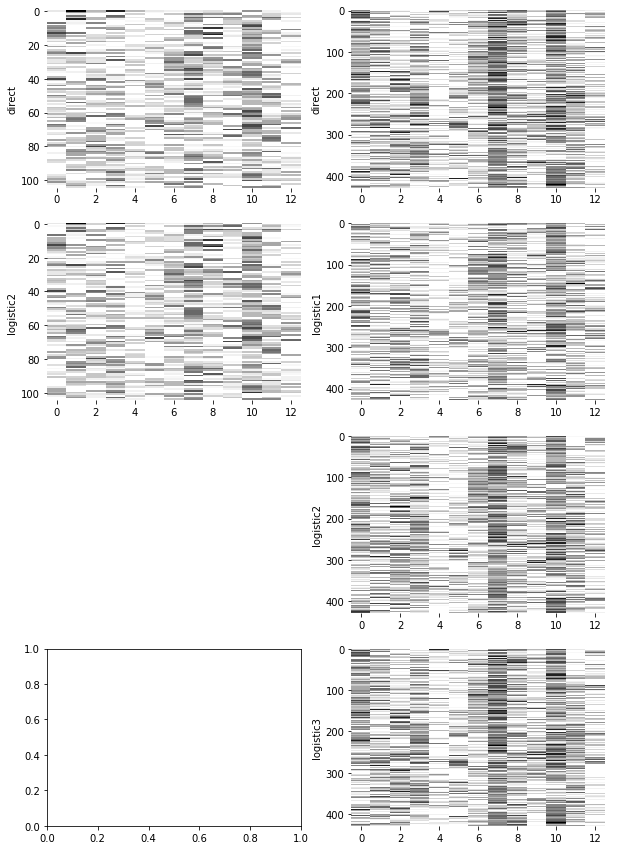

In [128]:
ch_nums = [2, 3]

fig, axes = plt.subplots(4, len(ch_nums), figsize=(10,15))

for i_ch, ch_num in enumerate(ch_nums):
    result_ch = all_results[i_ch]
    methods = set([r["method"] for r in result_ch])
    ch_groups = all_ch_groups[i_ch]
    n_methods = len(methods)
    for i_m, method in enumerate(methods):
        print("{}.{}".format(ch_num, method))
        fig.add_subplot(4, len(ch_nums), (i_m + 1) * (i_ch + 1), frameon=False)
        n_ch_groups = len(ch_groups)
        if (method == "direct" or method == "logistic3") and ch_num == 3: # incomplete results
            n_ch_groups = 429
        results = np.zeros((n_ch_groups, n_flies))
        for i_f in range(n_flies):
            ch_filtered = [r["score_mean"] for r in result_ch if \
                           (r["i_fly"] == i_f and \
                            r["method"] == method)
                            ]
            results[:, i_f] = np.array(ch_filtered)
        plt.grid(False)
        axes[i_m, i_ch].axis("off")
        im = plt.imshow(results, aspect="auto", vmin=0.5, vmax=1, cmap="Greys")
        plt.ylabel(method)
        #plt.colorbar()
        #if i_m == 0:
        #    plt.yticks(np.arange(len(ch_groups)), ch_groups)
        #else:
        #    plt.yticks
#fig.colorbar(im, ax=axes.ravel().tolist())

## Across-Trials, Across-Fly, Within-Channel Groups

This will give us 1 classification score for each channel group (for each method).

Each classification set will have `n_trials * n_conds * n_flies = 208` samples. 

In [ ]:
all_results = []

for i in range(2, 4):
    all_results += get_decoding_results(i, across_flies=True, multi_channel=False)

## Across-Trials, Within-Fly, Across-Channel Groups

This will give us 1 classification score for each fly (for each method).

Each classification set will have `n_trials * n_conds = 16` samples. Each sample will have a multidimensional independent variable, with the number of dimensions equalling the number of channel groups.

In [ ]:
all_results = []

for i in range(2, 4):
    all_results += get_decoding_results(i, across_flies=False, multi_channel=True)

In [62]:
decoding_results[0:4]

[{'i_fly': 0,
  'score_mean': 0.75,
  'score_std': 0.0680413817439772,
  'method': 'logistic2',
  'ch_num': 2},
 {'i_fly': 1,
  'score_mean': 0.8611111111111112,
  'score_std': 0.10393492741038726,
  'method': 'logistic2',
  'ch_num': 2},
 {'i_fly': 2,
  'score_mean': 0.9444444444444445,
  'score_std': 0.0785674201318386,
  'method': 'logistic2',
  'ch_num': 2},
 {'i_fly': 3,
  'score_mean': 0.6944444444444445,
  'score_std': 0.14163943093313291,
  'method': 'logistic2',
  'ch_num': 2}]

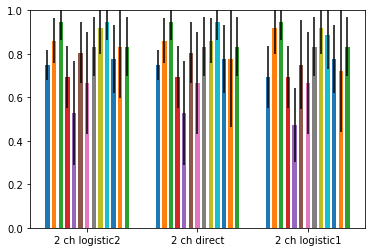

In [63]:
#colors = ["red", "blue", "green"]

n_methods = len(decoding_results) // n_flies

w = 0.04

mid_fly = n_flies // 2

for i_fly in range(n_flies):
    r_fly = [r for r in decoding_results if r.get("i_fly") == i_fly]
    x_pos = list(map(lambda x: x + ((i_fly - mid_fly) * (w*1.5)), range(n_methods)))
    heights = [r.get("score_mean") for r in r_fly]
    if i_fly == mid_fly:
        tick_labels = ["{} ch {}".format(r.get("ch_num"), r.get("method")) for r in r_fly]
    else:
        tick_labels = None
    plt.bar(x_pos,
            heights,
            width = w,
            tick_label = tick_labels,
            #color = [colors[r.get("ch_num") - 2] for r in r_fly],
            yerr = [r.get("score_std") for r in r_fly])
    plt.ylim((0, 1))

## Across-Trials, Across-Flies, Across-Channel Groups

This will give us 1 classification score (for each method).

Each classification set will have `n_trials * n_conds = 208` samples. Each sample will have a multidimensional independent variable, with the number of dimensions equalling the number of channel groups.

In [ ]:
all_results = []

for i in range(2, 4):
    all_results += get_decoding_results(i, across_flies=True, multi_channel=True)

/Users/wjmn/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/wjmn/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/wjmn/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [13]:
decoding_results

[{'score_mean': 0.6205882352941177,
  'score_std': 0.05499656001379745,
  'method': 'logistic2',
  'ch_num': 2},
 {'score_mean': 0.6253501400560224,
  'score_std': 0.048266727347384394,
  'method': 'direct',
  'ch_num': 2},
 {'score_mean': 0.6394957983193277,
  'score_std': 0.029646919084765022,
  'method': 'logistic1',
  'ch_num': 2}]

(0, 1)

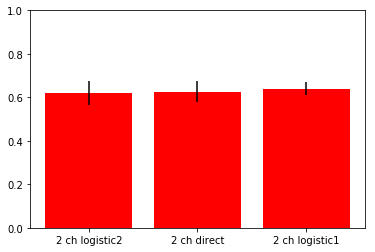

In [14]:
colors = ["red", "blue", "green"]

plt.bar(range(len(decoding_results)),
        [r.get("score_mean") for r in decoding_results],
        tick_label = ["{} ch {}".format(r.get("ch_num"), r.get("method")) for r in decoding_results],
        color = [colors[r.get("ch_num") - 2] for r in decoding_results],
        yerr = [r.get("score_std") for r in decoding_results])
plt.ylim((0, 1))